In [2]:
%matplotlib inline

from keras.models import load_model
from keras.utils import plot_model
from matplotlib import pyplot as plt
from matplotlib import pylab
import numpy as np
from sqlite3 import dbapi2 as sqlite
import pickle

Using TensorFlow backend.


## Color Normalize

True

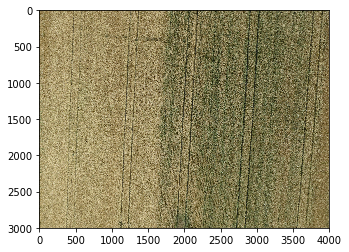

In [4]:
import cv2

# Reading the image
img = cv2.imread('./example_Img/IMG_7278.JPG', 1)
plt.imshow(plt.imread('./example_Img/IMG_7278.JPG'))

# Converting image to LAB Color model
hsv= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#cv2.imshow("lab",lab)

# Splitting the LAB image to different channels
h, s, v = cv2.split(hsv)
#cv2.imshow('l_channel', l)
#cv2.imshow('a_channel', a)
#cv2.imshow('b_channel', b)

# Applying CLAHE to L-channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
ch = clahe.apply(h)
cv = clahe.apply(v)
cs = clahe.apply(s)
#cv2.imshow('CLAHE output', cl)

# Merge the CLAHE enhanced H-channel with the a and b channel
limg = cv2.merge((h, cs, cv))
#cv2.imshow('limg', limg)

# Converting image from HSV Color model to RGB model
final = cv2.cvtColor(limg, cv2.COLOR_HSV2RGB)

# Transfer int to float64
plt.figure()
#cv2.imshow('final', final)
cv2.imwrite('./example_Img/color_no.JPG', final)

## Conv Layers

In [149]:
model = load_model('model.h5')

layer_dict = dict(
    [(layer.name, layer) for layer in model.layers])
layer_dict

{u'activation_1': <keras.layers.core.Activation at 0x7fa680dace50>,
 u'activation_2': <keras.layers.core.Activation at 0x7fa681112310>,
 u'activation_3': <keras.layers.core.Activation at 0x7fa681ba7250>,
 u'activation_4': <keras.layers.core.Activation at 0x7fa68125d450>,
 u'activation_5': <keras.layers.core.Activation at 0x7fa681264fd0>,
 u'conv2d_1': <keras.layers.convolutional.Conv2D at 0x7fa681e70590>,
 u'conv2d_2': <keras.layers.convolutional.Conv2D at 0x7fa681d39690>,
 u'conv2d_3': <keras.layers.convolutional.Conv2D at 0x7fa6822a9250>,
 u'dense_1': <keras.layers.core.Dense at 0x7fa684996950>,
 u'dense_2': <keras.layers.core.Dense at 0x7fa68125d9d0>,
 u'dropout_1': <keras.layers.core.Dropout at 0x7fa681b91fd0>,
 u'dropout_2': <keras.layers.core.Dropout at 0x7fa68125de50>,
 u'flatten_1': <keras.layers.core.Flatten at 0x7fa6849ab990>,
 u'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x7fa680dacb10>,
 u'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x7fa681ba7350>}

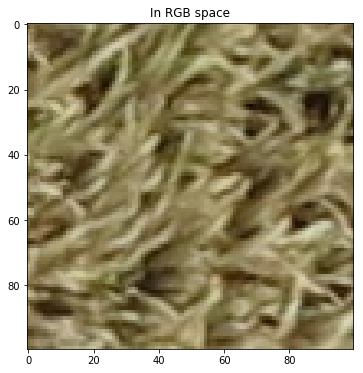

In [89]:
con = sqlite.connect('barley_30m.db')
c = con.cursor()

input_img = pickle.loads(
    c.execute('select rgb from img limit 1').fetchone()[0]
)
plt.imshow(input_img)
plt.title('In RGB space')

## Model structure

In [134]:
model.summary()
plot_model(model, to_file='model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
activation_3 (Activation)    (None, 50, 50, 128)       0         
__________

{u'activation_1': <keras.layers.core.Activation at 0x7fa68cb2af90>,
 u'activation_2': <keras.layers.core.Activation at 0x7fa68caffe90>,
 u'activation_3': <keras.layers.core.Activation at 0x7fa68ca43410>,
 u'activation_4': <keras.layers.core.Activation at 0x7fa68ca2d610>,
 u'activation_5': <keras.layers.core.Activation at 0x7fa68c9c7fd0>,
 u'conv2d_1': <keras.layers.convolutional.Conv2D at 0x7fa68cb36490>,
 u'conv2d_2': <keras.layers.convolutional.Conv2D at 0x7fa68caffc50>,
 u'conv2d_3': <keras.layers.convolutional.Conv2D at 0x7fa68caa43d0>,
 u'dense_1': <keras.layers.core.Dense at 0x7fa68ca1ad90>,
 u'dense_2': <keras.layers.core.Dense at 0x7fa68c9c7410>,
 u'dropout_1': <keras.layers.core.Dropout at 0x7fa68ca6b890>,
 u'dropout_2': <keras.layers.core.Dropout at 0x7fa68ca2d650>,
 u'flatten_1': <keras.layers.core.Flatten at 0x7fa68ca6bb90>,
 u'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x7fa68cb2aa90>,
 u'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x7fa68ca43510>}

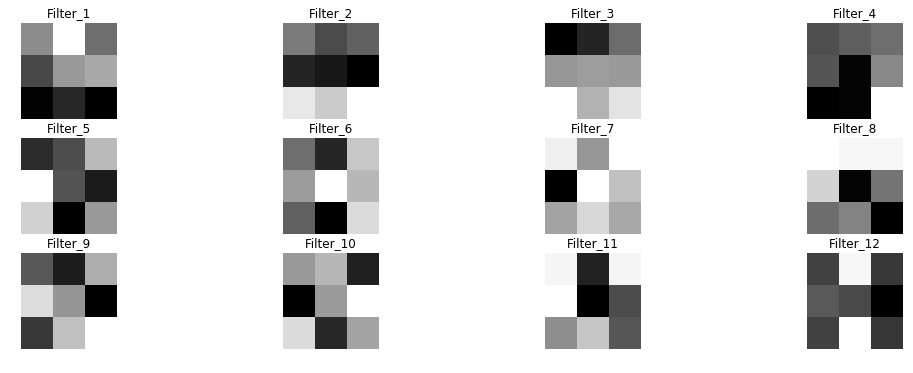

In [159]:
top_layer = model.layers[0]

plt.figure()
plt.axis('off')
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    plt.subplot(3, 4, i+1)
    filter_img = top_layer.get_weights()[0][:, :, :, i].squeeze()[:, :, 0]
    plt.imshow(
        filter_img,
        cmap=plt.get_cmap('gray'),
    )
    plt.title('Filter_{}'.format(i+1))
    plt.axis('off')
    #pylab.savefig('Filter_%s' %i)
    plt.imsave('./Filters/Filter_{}.png'.format(i), 
               filter_img, 
               cmap=plt.get_cmap('gray'))

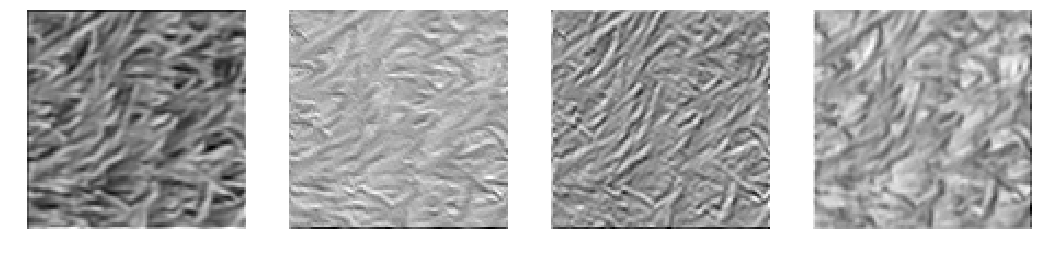

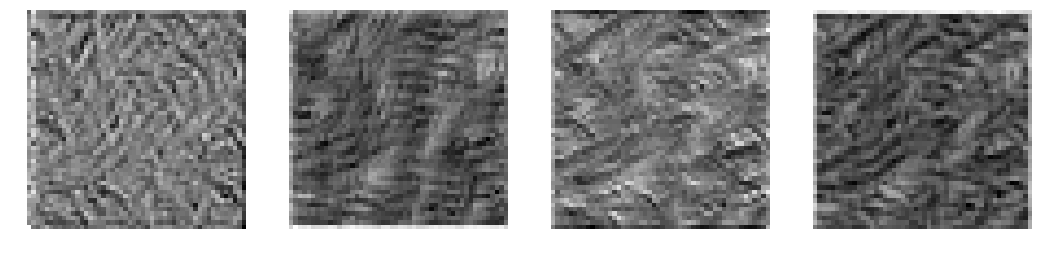

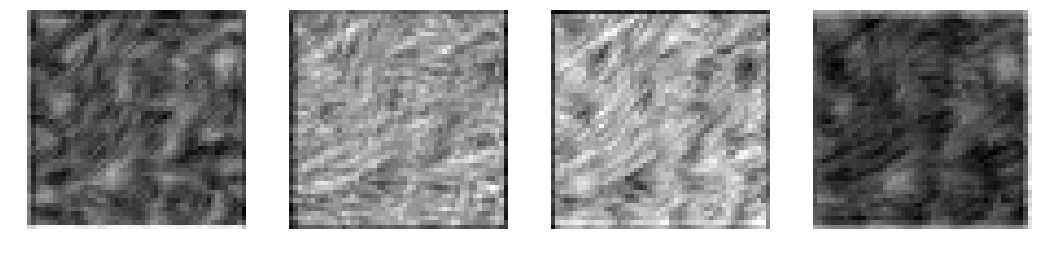

In [163]:
from keras import backend as K

get_output = K.function(
    [layer_dict.get('conv2d_1').input], 
    [
        layer_dict.get('conv2d_1').output, 
        layer_dict.get('conv2d_2').output,
        layer_dict.get('conv2d_3').output,
    ]
)
img = np.asarray([input_img])
vis_result = get_output([img])

for k in range(3):
    plt.figure()
    plt.title('ConvNet {}'.format(k+1))
    num = 4
    for i in range(4):
        plt.subplot(1, 4, i+1)
        output_im = vis_result[k][0, :, :, i] 
        plt.imshow(output_im, cmap=plt.get_cmap('gray'))
        plt.axis('off')
        plt.imsave('./ConvRE/conv_{}_filter_{}.png'.format(k+1, i+1),
                   output_im,
                   cmap=plt.get_cmap('gray'))

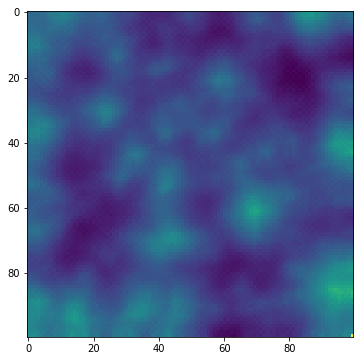

In [151]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = -1

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])